In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
dat = np.load("tiny_data.npz")

In [101]:
arr = dat.items()[0][1][:100, :]

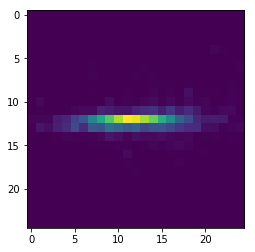

In [102]:
plt.imshow(arr[2].reshape((25, 25, 25))[:, 12, :])

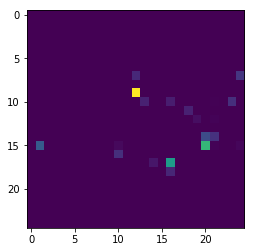

In [103]:
plt.imshow(arr[10].reshape((25, 25, 25))[:, 17, :])

In [104]:
import os
from datetime import datetime
from neon.callbacks.callbacks import Callbacks, GANCostCallback, LossCallback
#from neon.callbacks.plotting_callbacks import GANPlotCallback
from neon.initializers import Gaussian
from neon.layers import GeneralizedGANCost, Affine, Sequential, Conv, Deconv, Dropout, Pooling, BatchNorm
from neon.layers.layer import Linear, Reshape
from neon.layers.container import GenerativeAdversarial
from neon.models.model import GAN, Model
from neon.transforms import Rectlin, Logistic, GANCost, Tanh
from neon.util.argparser import NeonArgparser
from neon.util.persist import ensure_dirs_exist
from neon.layers.layer import Dropout
from neon.data.dataiterator import ArrayIterator
from neon.optimizers import GradientDescentMomentum, RMSProp
from neon.backends import gen_backend
import numpy as np
from sklearn.cross_validation import train_test_split

In [105]:
X = arr.copy()
y = np.ones(arr.shape[0])
# X[X < 1e-6] = 0

In [106]:
np.max(arr), np.min(arr)

(0.75065428, 0.0)

In [107]:
np.min(arr[np.nonzero(arr)])

2.8908387e-08

In [108]:
mean = np.mean(X, axis=0, keepdims=True) 
max_elem = np.max(np.abs(X))

In [109]:
X = (X - mean)/max_elem

In [110]:
np.max(X), np.min(X)

(0.87094337, -0.60051805)

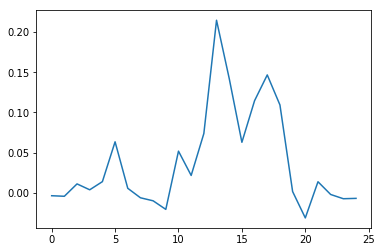

In [111]:
plt.plot(X[20].reshape((25, 25, 25))[12, 12, :])

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape, 'X train shape')
print(y_train.shape, 'y train shape')

(90, 15625) X train shape
(90,) y train shape


In [113]:
gen_backend(backend='cpu', batch_size=10)
train_set = ArrayIterator(X=X_train, y=y_train, nclass=2, lshape=(1, 25, 25, 25))
valid_set = ArrayIterator(X=X_test, y=y_test, nclass=2)

In [114]:
# setup weight initialization function
init = Gaussian(scale=0.01)

# discriminiator using convolution layers
lrelu = Rectlin(slope=0.1)  # leaky relu for discriminator
# sigmoid = Logistic() # sigmoid activation function
conv1 = dict(init=init, batch_norm=False, activation=lrelu, bias=init) # what's about BatchNorm Layer and batch_norm parameter?
conv2 = dict(init=init, batch_norm=False, activation=lrelu, padding=2, bias=init)
conv3 = dict(init=init, batch_norm=False, activation=lrelu, padding=1, bias=init)
D_layers = [
            Conv((5, 5, 5, 32), **conv1),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv3),
            BatchNorm(),
            Dropout(keep = 0.8),
            Pooling((2, 2, 2)),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1, init=init, activation=Logistic())
            ]

# generator using convolution layers
init_gen = Gaussian(scale=0.01)
relu = Rectlin(slope=0)  # relu for generator
pad1 = dict(pad_h=2, pad_w=2, pad_d=2)
str1 = dict(str_h=2, str_w=2, str_d=2)
conv1 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad1, strides=str1, bias=init_gen)
pad2 = dict(pad_h=2, pad_w=2, pad_d=2)
str2 = dict(str_h=2, str_w=2, str_d=2)
conv2 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad2, strides=str2, bias=init_gen)
pad3 = dict(pad_h=0, pad_w=0, pad_d=0)
str3 = dict(str_h=1, str_w=1, str_d=1)
conv3 = dict(init=init_gen, batch_norm=False, activation=Logistic(), padding=pad3, strides=str3, bias=init_gen)
G_layers = [
            Affine(1024, init=init_gen, bias=init_gen, activation=relu),
            BatchNorm(),
            Affine(8 * 7 * 7 * 7, init=init_gen, bias=init_gen),
            Reshape((8, 7, 7, 7)),
            Deconv((6, 6, 6, 6), **conv1), #14x14x14
            BatchNorm(),
            Deconv((5, 5, 5, 64), **conv2), #27x27x27
            BatchNorm(),
            Conv((3, 3, 3, 1), **conv3)
            ]

layers = GenerativeAdversarial(generator=Sequential(G_layers, name="Generator"),
                               discriminator=Sequential(D_layers, name="Discriminator"))

# setup optimizer
optimizer = RMSProp(learning_rate=1e-3, decay_rate=0.9, epsilon=1e-8)
#optimizer = GradientDescentMomentum(learning_rate=1e-3, momentum_coef = 0.9)

# setup cost function as Binary CrossEntropy
cost = GeneralizedGANCost(costfunc=GANCost(func="wasserstein"))

nb_epochs = 27
latent_size = 200
inb_classes = 2
nb_test = 100

# initialize model
noise_dim = (latent_size)
gan = GAN(layers=layers, noise_dim=noise_dim, k=5, wgan_param_clamp=0.9)

# configure callbacks
callbacks = Callbacks(gan, eval_set=valid_set)
callbacks.add_callback(GANCostCallback())
#callbacks.add_save_best_state_callback("./best_state.pkl")

# run fit
gan.fit(train_set, num_epochs=nb_epochs, optimizer=optimizer,
        cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|    9/9    batches, -0.01 cost, 128.50s]
Epoch 1   [Train |████████████████████|    9/9    batches, -0.10 cost, 137.28s]
Epoch 2   [Train |████████████████████|    9/9    batches, -0.18 cost, 134.87s]
Epoch 3   [Train |████████████████████|    9/9    batches, -0.30 cost, 126.87s]
Epoch 4   [Train |████████████████████|    9/9    batches, -0.36 cost, 126.69s]
Epoch 5   [Train |████████████████████|    9/9    batches, -0.37 cost, 144.71s]
Epoch 6   [Train |████████████████████|    9/9    batches, -0.39 cost, 132.88s]
Epoch 7   [Train |████████████████████|    9/9    batches, -0.45 cost, 130.99s]
Epoch 8   [Train |████████████████████|    9/9    batches, -0.35 cost, 139.40s]
Epoch 9   [Train |████████████████████|    9/9    batches, -0.32 cost, 119.02s]
Epoch 10  [Train |████████████████████|    9/9    batches, -0.41 cost, 127.16s]
Epoch 11  [Train |████████████████████|    9/9    batches, -0.54 cost, 127.36s]
Epoch 12  [Train |████████████████████| 

In [115]:
x_new = np.random.standard_normal((64, latent_size))
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(latent_size))
my_generator = Model(gan.layers.generator)

In [116]:
test5 = my_generator.get_outputs(inference_set)
test5 = test5 * max_elem + mean
test5 =  test5.reshape((64, 25, 25, 25))

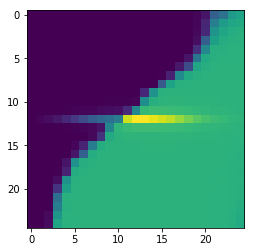

In [121]:
plt.imshow(test5[10, 12, :, :])

In [118]:
test5[10, 12, :, :]

array([[  1.04569939e-04,   1.23283589e-05,   3.59307194e-07,
          3.80401398e-05,   8.37579694e-09,   1.45181387e-08,
          3.15123325e-05,   8.96092024e-05,   2.72504349e-05,
          1.50823745e-08,   5.75177728e-09,   2.16548372e-07,
          2.05160777e-08,   4.33343412e-05,   1.94994740e-08,
          4.68365579e-06,   8.84835799e-07,   1.86112065e-05,
          2.92816287e-04,   1.45054618e-02,   6.71873167e-02,
          3.57248962e-01,   4.38690156e-01,   6.30094707e-01,
          6.78107858e-01],
       [  5.61473280e-06,   1.58884654e-06,   2.86992705e-08,
          2.96055296e-05,   2.86156654e-10,   1.24595356e-09,
          9.79834130e-11,   6.80181183e-05,   6.09469558e-11,
          1.26758681e-09,   7.98464589e-06,   1.02562367e-07,
          1.07145592e-09,   9.57828706e-06,   1.40434377e-05,
          1.13576661e-07,   3.32820018e-05,   3.08911731e-05,
          3.71583737e-04,   2.05229763e-02,   1.27643436e-01,
          4.97471660e-01,   6.40060604e-01,

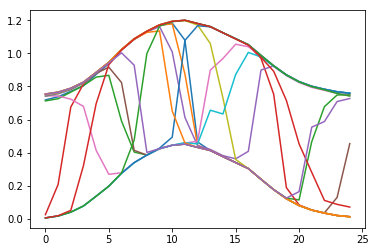

In [125]:
for i in range(15):
    plt.plot(test5[i, 12, 12, :])

In [24]:
x_new = np.random.standard_normal((64, latent_size))
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(latent_size))
my_generator = Model(gan.layers.generator)

Logistic

In [25]:
test2 = my_generator.get_outputs(inference_set)
test2 = test2 * max_elem + mean
test2 =  test2.reshape((64, 25, 25, 25))

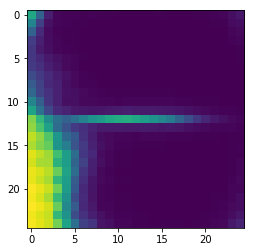

In [29]:
plt.imshow(test2[10, 12, :, :])

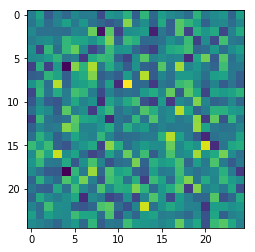

In [82]:
plt.imshow(test2[10, 17, :, :])

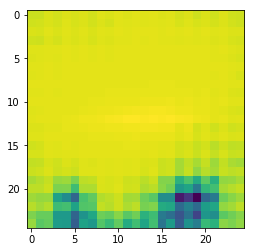

In [33]:
plt.imshow(test2[50, 10, :, :])

In [27]:
test2[0, 12, :, :]

array([[  2.94916987e-01,   2.54475892e-01,   3.87106299e-01,
          3.27655166e-01,   3.28443676e-01,   2.30097771e-01,
          1.90178066e-01,   1.15302198e-01,   4.46003564e-02,
          2.51692012e-02,   1.35830622e-02,   1.03740674e-02,
          3.32024763e-03,   3.88695416e-03,   1.91329478e-03,
          1.51231547e-03,   4.47395811e-04,   8.43887450e-04,
          7.00300385e-04,   1.62491726e-03,   1.68370898e-03,
          4.61846124e-03,   4.03964706e-03,   1.06798923e-02,
          1.51458820e-02],
       [  2.62527198e-01,   2.93538809e-01,   3.09314698e-01,
          3.68576884e-01,   2.65686929e-01,   2.04846010e-01,
          1.30794451e-01,   9.62916911e-02,   2.75059938e-02,
          1.45110860e-02,   4.91840672e-03,   4.18879278e-03,
          1.42678362e-03,   1.68587745e-03,   6.55992073e-04,
          3.89751891e-04,   1.89493614e-04,   2.92686105e-04,
          2.39571862e-04,   5.67483832e-04,   6.28220267e-04,
          2.33809231e-03,   2.50252406e-03,

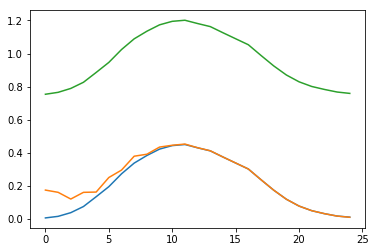

In [28]:
for i in range(3):
    plt.plot(test2[i, 12, 12, :])

Tanh - BAD!

In [16]:
test1 = my_generator.get_outputs(inference_set)
test1 = test1 * max_elem +  mean
test1 =  test1.reshape((64, 25, 25, 25))

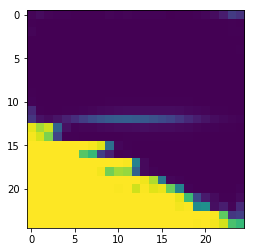

In [20]:
plt.imshow(test1[0, 12, :, :])

In [21]:
test1[0, 12, :, :]

array([[-0.73186255, -0.70838559, -0.73076278, -0.7378521 , -0.73563099,
        -0.74258453, -0.74377507, -0.74169677, -0.74144864, -0.73049754,
        -0.73786569, -0.72879845, -0.73800111, -0.7382552 , -0.73880988,
        -0.738545  , -0.74617618, -0.74432415, -0.74064726, -0.73823851,
        -0.72606295, -0.69946975, -0.63860804, -0.48807722, -0.5340606 ],
       [-0.74433976, -0.74817336, -0.74950331, -0.74834585, -0.74961168,
        -0.74996507, -0.75039876, -0.75003421, -0.75032425, -0.74907005,
        -0.74969983, -0.7485801 , -0.74889177, -0.74848074, -0.74887705,
        -0.74797517, -0.74953514, -0.74853373, -0.75022221, -0.74980599,
        -0.749901  , -0.74494278, -0.74701029, -0.7446422 , -0.74641895],
       [-0.73250878, -0.74811387, -0.74973375, -0.75015855, -0.75036556,
        -0.75046802, -0.75059319, -0.75039876, -0.75050634, -0.75012869,
        -0.75034648, -0.75030029, -0.75048679, -0.75027895, -0.75046378,
        -0.75026113, -0.75014061, -0.74958056, -0

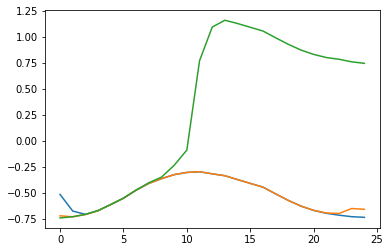

In [22]:
for i in range(3):
    plt.plot(test1[i, 12, 12, :])

lrelu

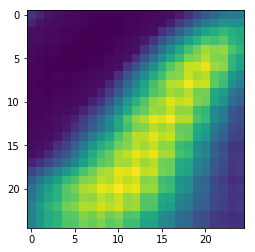

In [18]:
plt.imshow(test[0, 12, :, :])

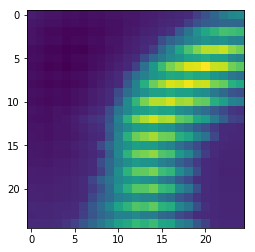

In [25]:
plt.imshow(test[12, :, 12, :])

In [23]:
test[0, :, 12, :]

array([[ -3.23507726e-01,  -3.69014859e-01,  -4.29053515e-01,
         -4.27997082e-01,  -4.87558275e-01,  -4.65426594e-01,
         -4.81737435e-01,  -4.21977431e-01,  -4.30315495e-01,
         -3.70258927e-01,  -3.49416375e-01,  -2.70546347e-01,
         -2.44161233e-01,  -1.81070819e-01,  -1.32862106e-01,
         -6.21860325e-02,  -2.15816908e-02,   2.73145050e-01,
          7.27748513e-01,   1.34738791e+00,   1.82193816e+00,
          2.40478039e+00,   2.97808909e+00,   3.24957108e+00,
          3.25743604e+00],
       [ -4.11927462e-01,  -4.42136377e-01,  -5.13085365e-01,
         -4.91857886e-01,  -5.64724803e-01,  -5.19982696e-01,
         -5.44743359e-01,  -4.61116463e-01,  -4.74745303e-01,
         -3.90158951e-01,  -3.55552703e-01,  -2.46610746e-01,
         -2.04922378e-01,  -1.22990936e-01,  -5.78272343e-02,
          1.62317321e-01,   5.74688435e-01,   9.03398097e-01,
          1.39684319e+00,   1.74004507e+00,   2.02748418e+00,
          2.01466227e+00,   2.21289325e+00,

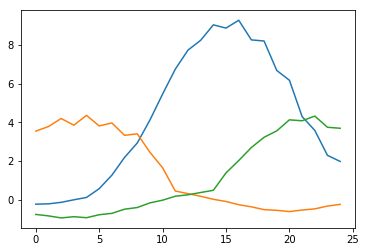

In [21]:
for i in range(3):
    plt.plot(test[i, 12, 12, :])

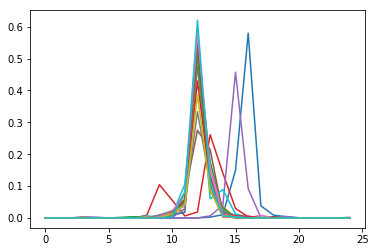

In [22]:
for i in range(20):
    plt.plot(arr[i].reshape((25, 25, 25))[:, 12, 12])

#### 

In [126]:
gen_backend(backend='cpu', batch_size=10)
# setup weight initialization function
init = Gaussian(scale=0.01)

# discriminiator using convolution layers
lrelu = Rectlin(slope=0.1)  # leaky relu for discriminator
# sigmoid = Logistic() # sigmoid activation function
conv1 = dict(init=init, batch_norm=False, activation=lrelu, bias=init) # what's about BatchNorm Layer and batch_norm parameter?
conv2 = dict(init=init, batch_norm=False, activation=lrelu, padding=2, bias=init)
conv3 = dict(init=init, batch_norm=False, activation=lrelu, padding=1, bias=init)
D_layers = [
            Conv((5, 5, 5, 32), **conv1),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv3),
            BatchNorm(),
            Dropout(keep = 0.8),
            Pooling((2, 2, 2)),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1, init=init, activation=Logistic())
            ]

# generator using convolution layers
init_gen = Gaussian(scale=0.01)
relu = Rectlin(slope=0)  # relu for generator
pad1 = dict(pad_h=2, pad_w=2, pad_d=2)
str1 = dict(str_h=2, str_w=2, str_d=2)
conv1 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad1, strides=str1, bias=init_gen)
pad2 = dict(pad_h=2, pad_w=2, pad_d=2)
str2 = dict(str_h=2, str_w=2, str_d=2)
conv2 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad2, strides=str2, bias=init_gen)
pad3 = dict(pad_h=0, pad_w=0, pad_d=0)
str3 = dict(str_h=1, str_w=1, str_d=1)
conv3 = dict(init=init_gen, batch_norm=False, activation=Tanh(), padding=pad3, strides=str3, bias=init_gen)
G_layers = [
            Affine(1024, init=init_gen, bias=init_gen, activation=relu),
            BatchNorm(),
            Affine(8 * 7 * 7 * 7, init=init_gen, bias=init_gen),
            Reshape((8, 7, 7, 7)),
            Deconv((6, 6, 6, 6), **conv1), #14x14x14
            BatchNorm(),
            Deconv((5, 5, 5, 64), **conv2), #27x27x27
            BatchNorm(),
            Conv((3, 3, 3, 1), **conv3)
            ]

layers = GenerativeAdversarial(generator=Sequential(G_layers, name="Generator"),
                               discriminator=Sequential(D_layers, name="Discriminator"))

# setup optimizer
optimizer = RMSProp(learning_rate=1e-3, decay_rate=0.9, epsilon=1e-8)
# optimizer = GradientDescentMomentum(learning_rate=1e-3, momentum_coef = 0.9)

# setup cost function as Binary CrossEntropy
cost = GeneralizedGANCost(costfunc=GANCost(func="modified"))

nb_epochs = 27
latent_size = 200
inb_classes = 2
nb_test = 100

# initialize model
noise_dim = (latent_size)
gan = GAN(layers=layers, noise_dim=noise_dim, k=5)

# configure callbacks
callbacks = Callbacks(gan, eval_set=valid_set)
callbacks.add_callback(GANCostCallback())
#callbacks.add_save_best_state_callback("./best_state.pkl")

# run fit
gan.fit(train_set, num_epochs=nb_epochs, optimizer=optimizer,
        cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|    9/9    batches, 1.98 cost, 138.55s]
Epoch 1   [Train |████████████████████|    9/9    batches, 1.41 cost, 150.99s]
Epoch 2   [Train |████████████████████|    9/9    batches, 1.46 cost, 146.70s]
Epoch 3   [Train |████████████████████|    9/9    batches, 1.44 cost, 131.60s]
Epoch 4   [Train |████████████████████|    9/9    batches, 1.44 cost, 130.86s]
Epoch 5   [Train |████████████████████|    9/9    batches, 1.43 cost, 122.69s]
Epoch 6   [Train |████████████████████|    9/9    batches, 1.43 cost, 140.25s]
Epoch 7   [Train |████████████████████|    9/9    batches, 1.44 cost, 147.38s]
Epoch 8   [Train |████████████████████|    9/9    batches, 1.42 cost, 147.91s]
Epoch 9   [Train |████████████████████|    9/9    batches, 1.42 cost, 138.45s]
Epoch 10  [Train |████████████████████|    9/9    batches, 1.43 cost, 139.10s]
Epoch 11  [Train |████████████████████|    9/9    batches, 1.44 cost, 133.15s]
Epoch 12  [Train |████████████████████|    9/9    ba

In [127]:
x_new = np.random.standard_normal((64, latent_size))
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(latent_size))
my_generator = Model(gan.layers.generator)

In [128]:
test6 = my_generator.get_outputs(inference_set)
test6 = test6 * max_elem +  mean
test6 =  test6.reshape((64, 25, 25, 25))

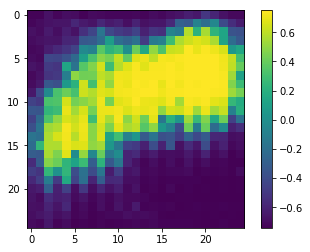

In [133]:
plt.imshow(test6[20, 20, :, :])
plt.colorbar()

In [62]:
x_new = np.random.standard_normal((64, latent_size))
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(latent_size))
my_generator = Model(gan.layers.generator)

In [ ]:
Tanh - modified

In [63]:
test4 = my_generator.get_outputs(inference_set)
test4 = test4 * max_elem +  mean
test4 =  test4.reshape((64, 25, 25, 25))

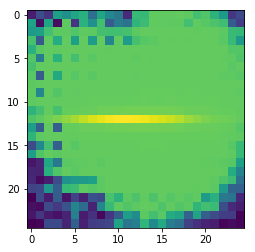

In [80]:
plt.imshow(test4[10, 12, :, :])

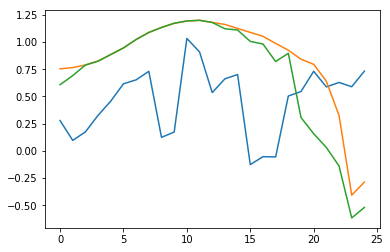

In [83]:
for i in range(3):
    plt.plot(test4[i, 12, 12, :])

In [52]:
test3 = my_generator.get_outputs(inference_set)
test3 = test3 * max_elem +  mean
test3 =  test3.reshape((64, 25, 25, 25))

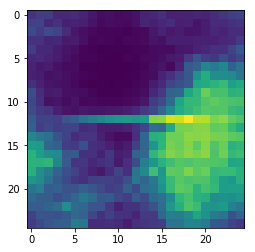

In [58]:
plt.imshow(test3[0, 12, :, :])

In [57]:
test3[10, 12, :, :]

array([[ 0.46928039,  0.53032559,  0.62184447,  0.65278566,  0.63975871,
         0.58877474,  0.70148343,  0.72083676,  0.74020362,  0.73519844,
         0.72475958,  0.7130813 ,  0.71702796,  0.72802502,  0.73544824,
         0.72019041,  0.69729513,  0.69893557,  0.70337617,  0.65563941,
         0.68684614,  0.65892041,  0.65059441,  0.42228428,  0.29226133],
       [ 0.54599124,  0.67028689,  0.72405934,  0.71098429,  0.71205014,
         0.71805561,  0.71853131,  0.71168077,  0.73276561,  0.72885436,
         0.73765796,  0.71906245,  0.7271542 ,  0.70999771,  0.73095012,
         0.71156949,  0.70077705,  0.66976744,  0.68031245,  0.69400215,
         0.72593206,  0.71683371,  0.64053428,  0.58173531,  0.4547326 ],
       [ 0.71622103,  0.72840101,  0.74926448,  0.74731171,  0.74938852,
         0.74741954,  0.74497712,  0.74790549,  0.74782568,  0.74547261,
         0.74846828,  0.74677485,  0.74793148,  0.74762899,  0.74396646,
         0.73480469,  0.73706061,  0.72051054,  0

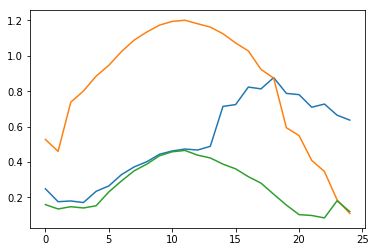

In [60]:
for i in range(3):
    plt.plot(test3[i, 12, 12, :])

Tanh() - modified

lrelu - wasserstain

In [42]:
x_new = np.random.standard_normal((64, latent_size))
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(latent_size))
my_generator = Model(gan.layers.generator)

In [43]:
test2 = my_generator.get_outputs(inference_set)
test2 = test2 * max_elem +  mean
test2 =  test2.reshape((64, 25, 25, 25))

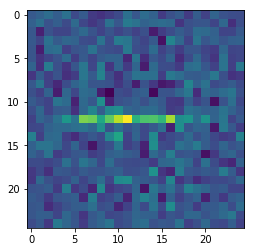

In [48]:
plt.imshow(test2[10, 12, :, :])

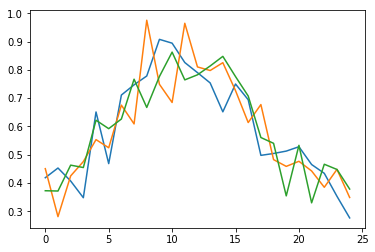

In [45]:
for i in range(3):
    plt.plot(test2[i, 12, 12, :])

In [55]:
test2[10, 12, :, :]

array([[ 0.39387944,  0.4174394 ,  0.4529663 ,  0.40683782,  0.46367899,
         0.35278118,  0.39859015,  0.3097173 ,  0.29202551,  0.32109767,
         0.35192862,  0.45910251,  0.38609758,  0.44729459,  0.41681683,
         0.31529155,  0.36582935,  0.39771789,  0.31522304,  0.40234879,
         0.33231145,  0.42207986,  0.37133545,  0.36224511,  0.35846663],
       [ 0.41275615,  0.45624769,  0.37253827,  0.40807387,  0.35359237,
         0.44156817,  0.34210983,  0.30491057,  0.34082106,  0.46276465,
         0.38707474,  0.48893172,  0.46567094,  0.41853386,  0.43801901,
         0.44738185,  0.43709633,  0.29796657,  0.36534318,  0.38023207,
         0.38427058,  0.33961305,  0.43445045,  0.28448188,  0.36280653],
       [ 0.38720897,  0.25161383,  0.37113699,  0.33956498,  0.34004799,
         0.39492658,  0.43842557,  0.37908676,  0.33428615,  0.37720221,
         0.33912048,  0.37076312,  0.33213612,  0.36724123,  0.23987003,
         0.31948617,  0.36057785,  0.40270689,  0